In [57]:
import timm
import torch
from PIL import Image
import numpy as np

# %load "../segmentation.py"
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

torch.manual_seed(0)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
model = timm.create_model("efficientnet_b0", num_classes=116)

In [59]:
trained_model = torch.load("../models/efficientnet_b0_9982.pt", map_location=torch.device("cpu"))

In [60]:
model.load_state_dict(trained_model["model_state_dict"])

<All keys matched successfully>

In [61]:
with open("../labels.txt") as f:
    prod = []
    for line in f.readlines():
        prod.append(line)

In [62]:
def infer(image_path,model):
   img = Image.open(image_path)
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      return prod[index].strip(), output

def infer_video(frame,model):
   frame = frame[256:812,512:1216,]
   img = Image.fromarray(np.uint8(frame)).convert('RGB')
   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
      return output.max(), frame, frame.mean()

def get_ratio(image):
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    return ratio

In [63]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [64]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

100%|██████████| 1799/1799 [00:35<00:00, 50.40it/s]


testA_1.mp4


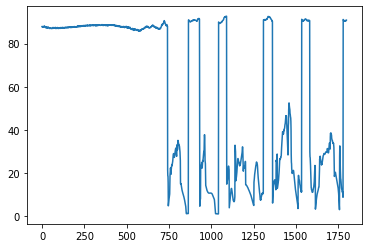

100%|██████████| 1499/1499 [00:32<00:00, 46.39it/s]


testA_2.mp4


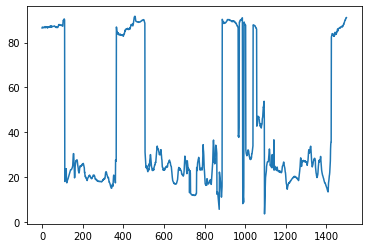

100%|██████████| 3642/3642 [01:31<00:00, 40.01it/s]


testA_3.mp4


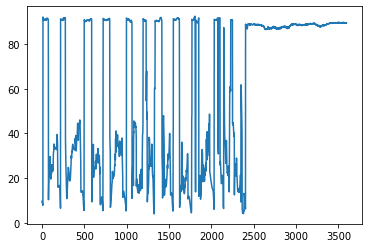

100%|██████████| 2123/2123 [00:51<00:00, 41.09it/s]


testA_4.mp4


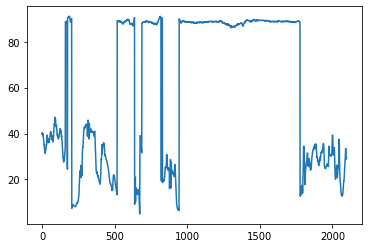

100%|██████████| 1547/1547 [00:36<00:00, 42.89it/s]


testA_5.mp4


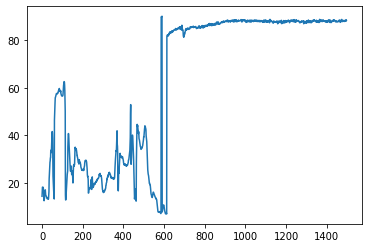

In [65]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

video_location = "../test-videos/"
videos = ["testA_1.mp4","testA_2.mp4","testA_3.mp4","testA_4.mp4","testA_5.mp4",]
images_list = []
ratios_list = []

for video in videos:
  vidcap = cv2.VideoCapture(video_location+video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[256:896, 512:1400]
      image = automatic_brightness_and_contrast(image)
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []

  for img in resized_image:
    ratio = get_ratio(img)
    ratios.append(ratio)
  
  images_list.append(resized_image)
  ratios_list.append(ratios)

  print(video)
  plt.plot(ratios)
  plt.show()

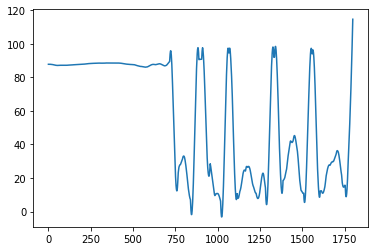

NEXT


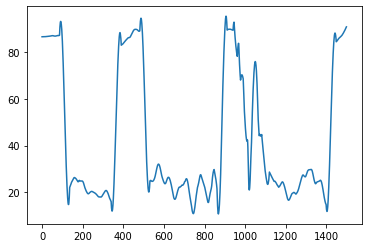

NEXT


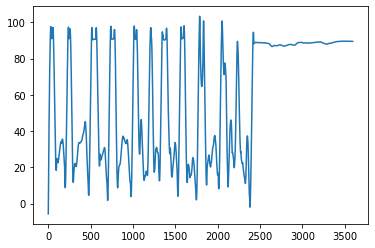

NEXT


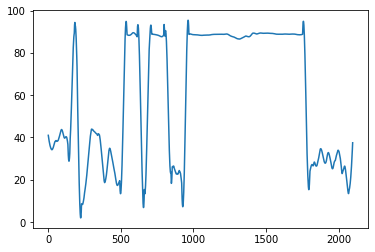

NEXT


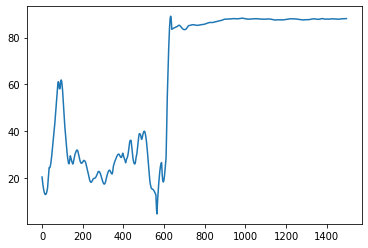

NEXT


In [66]:
from scipy.signal import savgol_filter, argrelextrema
images_with_object = []

count = 1
for images, ratios in zip(images_list, ratios_list):
    frames_with_object = []
    rolling_ratios = savgol_filter(ratios, 50, 2)
    maximas = argrelextrema(rolling_ratios, np.greater, order = 50)
    for maxima in maximas[0]:
        colorfulness = image_colorfulness(images[maxima])
        if(colorfulness>20):
            frames_with_object.append((images[maxima],maxima))
            count+=1
            # plt.imshow(images[maxima])
            # plt.show() 
    plt.plot(rolling_ratios)
    plt.show()
    print("NEXT")
    images_with_object.append(frames_with_object)

In [67]:
model_path = '../models/unet_aicityt4.pth'

import torchvision

###### UNet model
#########################################################################################
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        # NOTE: 
        # nn.Conv2d(64, 1, kernel_size=1, padding=0) is mathematically same as 
        # nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs
######################################################################################### 

# Define model
segmentation_model = build_unet()
checkpoint = torch.load(model_path, map_location="cpu")
segmentation_model.load_state_dict(checkpoint)
# Send to GPU
segmentation_model = segmentation_model.to(DEVICE)
segmentation_model.eval()

def visualize(idx, **images):
    """Plot images in one row.""" 
    n = len(images)
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).lower(), fontsize=20)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
        plt.show()

        #plt.tight_layout()
    #plt.savefig("../outputs/vis/compare-segs/{}.png".format(idx), facecolor="white", bbox_inches = 'tight')


In [68]:
#To use this block, run `pip install pytorch-lightning`
#Reference: https://github.com/guglielmocamporese/hands-segmentation-pytorch

# Imports
import torch
import torch.hub

# Create the model
hand_seg_model = torch.hub.load(
    repo_or_dir='guglielmocamporese/hands-segmentation-pytorch', 
    model='hand_segmentor', 
    pretrained=True
)
hand_seg_model.eval()

Using cache found in /home/istiak_admin/.cache/torch/hub/guglielmocamporese_hands-segmentation-pytorch_master
Downloading...
From: https://drive.google.com/uc?id=1w7dztGAsPHD_fl_Kv_a8qHL4eW92rlQg
To: /home/istiak_admin/Codes/classification-pipeline-2/notebooks/checkpoint/checkpoint.ckpt
100%|██████████| 476M/476M [01:08<00:00, 6.98MB/s] 


HandSegModel(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [69]:
def crop_with_hand_seg(img):
    """
    Crops product image using product and hand segmentation.
    """
        
    transforms_image = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.CenterCrop((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    image_b = torch.unsqueeze(transforms_image(img), 0)
    image = (image_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    pred = hand_seg_model(image_b).argmax(1).detach().cpu().numpy().squeeze()
    # invert mask, use plt.imshow(hand_pred) for vis
    hand_pred = np.logical_not(pred).astype(int) 
    
    # Stack preds for getting ROI
    hand_pred3d = np.stack((hand_pred, hand_pred, hand_pred), axis=-1)
    # Get rid off hands
    image_no_hands = np.array(image) * hand_pred3d # use plt.imshow(image_no_hands) for vis
    
    # Convert new image to tensor
    image_no_hands = Image.fromarray(np.uint8(image_no_hands)).convert('RGB')
    image_tensor = transforms_image(image_no_hands)

    image_tensor_b = torch.unsqueeze(image_tensor, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    
    # Image ROI
    image_roi = image_no_hands * mask

    
    return image_roi

In [70]:
def preprocess_image_classification(frame):
   img = Image.fromarray(frame).convert('RGB')

   mean = [0.485, 0.456, 0.406] 
   std = [0.229, 0.224, 0.225]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   return img_normalized

def get_segmentation(image):
   transforms_image = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.CenterCrop((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
   image_tensor = transforms_image(image)
   image_tensor_b = torch.unsqueeze(image_tensor, 0).to(DEVICE)
   output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
   pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
   img = (image_tensor_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
   img = (img*255).astype(np.uint8)
   mask = np.stack((pred, pred, pred), axis=-1)
   image_roi = img * mask
   return image_roi

def infer_frame(frame, model):
   img = Image.fromarray(frame).convert('RGB')

   image_roi = crop_with_hand_seg(img)
   plt.imshow(image_roi[:,:,[2,1,0]])
   plt.show()
   img_normalized = preprocess_image_classification(frame=image_roi[:,:,[2,1,0]])
   img_normalized = img_normalized.unsqueeze_(0)
   img_normalized = img_normalized.to("cpu")
   with torch.no_grad():
      model.eval()
      output =model(img_normalized)
      index = output.data.cpu().numpy().argmax()
      op_array = output.data.cpu().numpy()
      print(op_array[0][index])
      return index+1


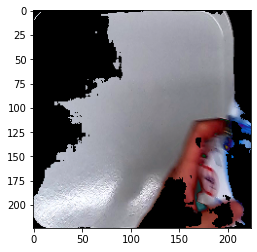

0.87136954
Flonase,41



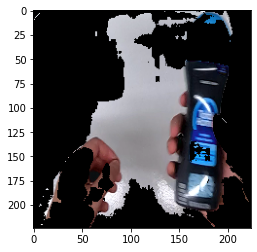

2.2614024
Unstoppables,109



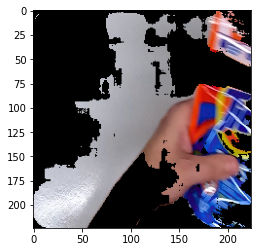

0.123726934
All Free and Clear Pods,6



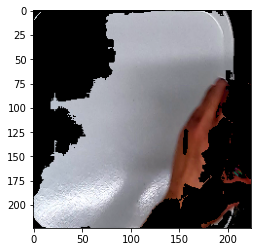

1.0794333
Peet's Coffee Grounds Dark Roast,85



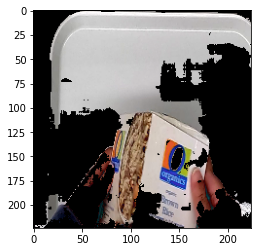

1.7619462
Flonase,41



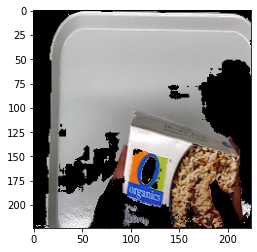

0.04170921
Brown Rice,18



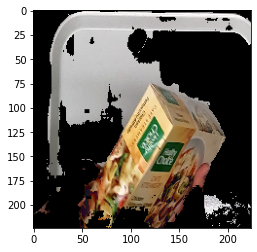

5.924531
Healthy Choice Chicken Alfredo,54



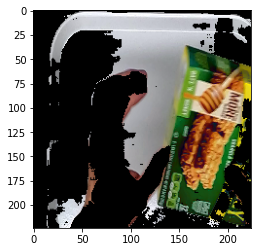

-0.34615222
Flonase,41



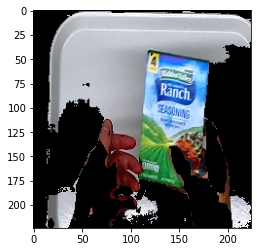

1.5276713
Ranch Seasoning,91



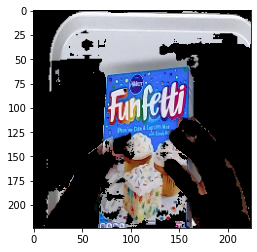

-0.12639315
French Roast Starbucks,43



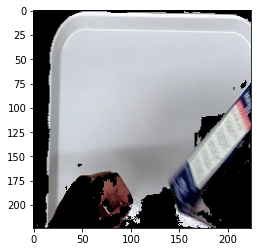

-0.3183216
Flonase,41



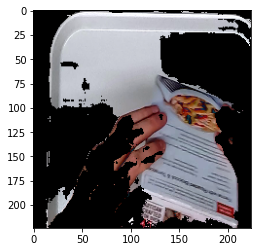

2.4847622
Gluten Free Pasta,52



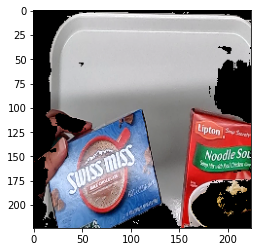

0.3845405
Swiss Miss Hot Chocolate,101



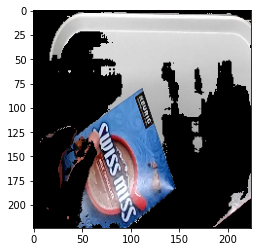

1.1770566
Swiss Miss Hot Chocolate,101



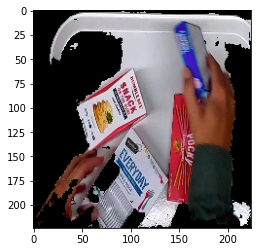

0.83000374
Flonase,41



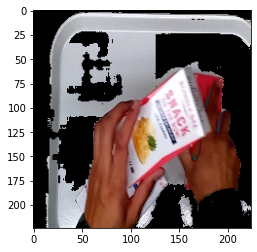

2.4460092
Unstoppables,109



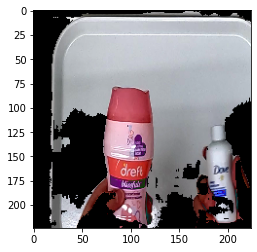

5.5434318
Unstoppables,109



In [71]:

video_id = []
object_id = []
timestamp = []
for idx in range(len(images_with_object)):
    for image,frame in images_with_object[idx]:
        video_id.append(idx+1)
        output = infer_frame(image, model)
        object_id.append(output)
        print(prod[output-1])
        timestamp.append(int(frame/60))  

In [73]:
with open('submission_hand_segment.txt', 'w') as f:
    for vid, obj, tim in zip(video_id, object_id, timestamp):
        f.write(f'{vid} {obj} {tim}\n')
    f.close()